In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import os
from math import cos, sin, pi, sqrt
from math import radians
%matplotlib inline

In [5]:
sealion_types = ["adult_males", 
    "subadult_males",
    "adult_females",
    "juveniles",
    "pups"]

In [6]:
sealion_probabilities = {'adult_females': 0.048142699511667254,
 'adult_males': 0.3351506883474506,
 'juveniles': 0.089826648353188876,
 'pups': 0.11096914409391793,
 'subadult_males': 0.41591081969377525}

In [7]:
def gaussian2d_gen(x, y, theta, sx=1, sy=1, x0=0, y0=0, A=1):
    """ See https://fr.wikipedia.org/wiki/Fonction_gaussienne
    """    
    assert(sx != 0)
    assert(sy != 0)
    a = (cos(theta)**2) / (2 * sx**2) + (sin(theta)** 2)/ (2 * sy**2)
    b = -sin(2 * theta)/ (4 * sx**2) + sin(2 * theta) / (4 * sy**2)
    c = (sin(theta)**2) / (2 * sx**2) + (cos(theta)** 2)/ (2 * sy**2)
    dx = x - x0
    dy = y - y0
    
    return A * np.exp(-(a * dx**2 + 2 * b * dx * dy + c * dy**2))

In [8]:
def mask_gaussian(major, minor, theta):
    """ See http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/ for the 5.991
    """
    df = 4.605 #5.991
    sigma_x = major/(2 * sqrt(df))
    sigma_y = minor/(2 * sqrt(df))
    half = int((max(sigma_x, sigma_y) * 3.5 ))  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d_gen(x, y, theta, sigma_x, sigma_y, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

In [18]:
def create_ellipse_density_map(shape, ellipses):
    dmap = np.zeros(shape + (len(sealion_types),), np.float32)
    
    for tid, es in enumerate(ellipses):
        for ((xc, yc), (major, minor), theta_deg) in es:                
            theta_deg = -theta_deg # because axis are not the same for the opencv ellipse
            theta_rad = radians(theta_deg)
            mask = mask_gaussian(major, minor, theta_rad)
    
            hmask, wmask = mask.shape
            hmask2 = hmask//2
            wmask2 = wmask//2
            
            xc = int(round(xc))
            yc = int(round(yc))
            xmin = max(0, xc - wmask2)
            xmax = min(dmap.shape[1] - 1, xc + wmask2)
            ymin = max(0, yc - hmask2)
            ymax = min(dmap.shape[0] - 1, yc + hmask2)

            dy_top = yc - ymin
            dy_bottom = ymax - yc
            dx_left = xc - xmin
            dx_right = xmax - xc
            dmap[ymin:ymax+1, xmin:xmax+1, tid] += mask[hmask2 - dy_top: hmask2 + dy_bottom + 1,\
                                                         wmask2 - dx_left: wmask2 + dx_right + 1] 
    return dmap.astype(np.float32)

In [19]:
def split_in_blocks(im_raw, dmap, n_blocks=(4,4), overlap=(448,448)):
    h, w = im_raw.shape[:2]
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    
    if (w + (n_blocks[1] - 1) * overlap[1]) % n_blocks[1] != 0 or \
        (h + (n_blocks[0] - 1) * overlap[0]) % n_blocks[0] != 0:
            print("Warning: check the number of blocks and overlap")
            
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            yield im_raw[y_start:y_end, x_start:x_end,...], dmap[y_start:y_end, x_start:x_end,...]

In [20]:
def generate_training_blocks(root_dir):
    raw_dir = os.path.join(root_dir, "Train")
    ellipses_dir = os.path.join(root_dir, "TrainEllipses")
    mask_dir = os.path.join(root_dir, "TrainMask")
    dmap_dir = os.path.join(root_dir, "TrainEllipseDensity")
    block_dir = os.path.join(root_dir, "TrainBlock")
    
    os.makedirs(dmap_dir, exist_ok=True)
    os.makedirs(block_dir, exist_ok=True)
    
    for filename in os.listdir(raw_dir):
        if not filename.endswith(".jpg"):
            continue
        
        train_id, _ = os.path.splitext(filename)
        # load the raw image, mask and dots
        im_raw = cv2.imread(os.path.join(raw_dir, filename))
        im_mask = cv2.imread(os.path.join(mask_dir, train_id + ".png"), cv2.IMREAD_GRAYSCALE)
        with open(os.path.join(ellipses_dir, train_id + ".pkl"), "rb") as pfile:
            ellipses = pickle.load(pfile)
            
        # Create the density map and sampling map
        dmap = create_ellipse_density_map(im_raw.shape[:2], ellipses)
        
        # Apply mask on all
        im_raw[im_mask==0, ...] = 0
        dmap[im_mask==0, ...] = 0
        
        # Generate blocks and save them
        for i, (braw, bdmap) in enumerate(split_in_blocks(im_raw, dmap)):
            cv2.imwrite(os.path.join(block_dir, "{tid}_{bid}.jpg".format(tid=train_id, bid=i)), braw)
            np.savez_compressed(os.path.join(dmap_dir, "{tid}_{bid}.npz".format(tid=train_id, bid=i)), dmap=bdmap)

In [36]:
generate_training_blocks("/home/lowik/sealion/data/sealion/")

(3335, 2376) (21.564124469882767, 48.0) -9.865806579589844
(3335, 2376) (21.564124469882767, 48.0) -9.865806579589844
(3357, 2370) (48.0, 42.66666343401501) -74.05460357666016
(3357, 2370) (48.0, 42.66666343401501) -74.05460357666016
(3346, 2386) (28.0, 24.0) -0.0
(3346, 2386) (28.0, 24.0) -0.0
(3355, 2368) (33.6271186440678, 64.0) -0.0
(3355, 2368) (33.6271186440678, 64.0) -0.0
(3343, 2364) (34.11764705882353, 60.0) -0.0
(3343, 2364) (34.11764705882353, 60.0) -0.0
(3335, 2371) (48.0, 36.0) -0.0
(3335, 2371) (48.0, 36.0) -0.0
(3348, 2377) (38.07234549369641, 78.0) -60.524105072021484
(3348, 2377) (38.07234549369641, 78.0) -60.524105072021484
(3359, 2373) (53.68421052631579, 60.0) -0.0
(3359, 2373) (53.68421052631579, 60.0) -0.0


In [33]:
def show_density(im, density):
    max_density = np.max(density)
    normalized_density = density/max_density
    im_fp32 = im.astype(np.float32)
    im_masked = im_fp32.copy()
    im_masked[:,:,0] = (im_fp32[:,:,0] * normalized_density)
    im_masked[:,:,1] = (im_fp32[:,:,1] * normalized_density)
    im_masked[:,:,2] = (im_fp32[:,:,2] * normalized_density)
    return im_masked.astype(np.uint8), (normalized_density * 255).astype(np.uint8)

In [22]:
with open("../data/sealion/TrainEllipses/868.pkl", "rb") as ifile:
    ellipses = pickle.load(ifile)

In [23]:
im_train = cv2.imread("../data/sealion/TrainBlock/868_5.jpg")

In [24]:
dmap = np.load("../data/sealion/TrainEllipseDensity/868_5.npz")["dmap"]

In [29]:
dmap = np.sum(dmap, axis=-1)

In [31]:
np.sum(dmap)

52.943577

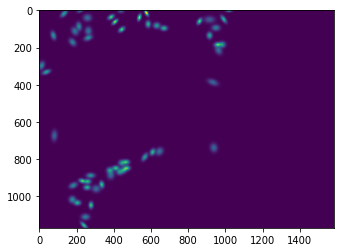

In [30]:
plt.imshow(dmap)

In [34]:
im_density, mask_density = show_density(im_train, dmap)

In [35]:
cv2.imwrite("../data/imk.png", im_density)
cv2.imwrite("../data/kk.png", mask_density)

True